0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
14
1

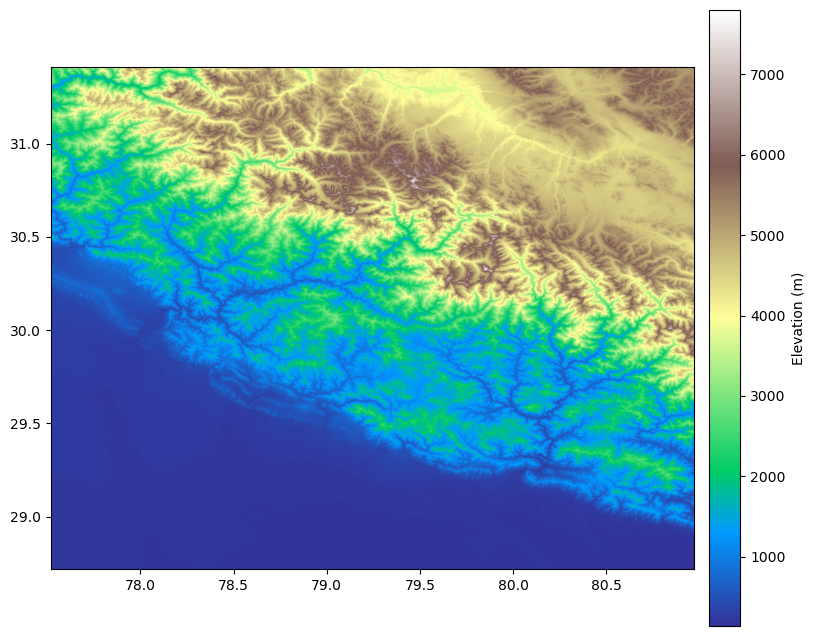

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.animation import FuncAnimation

# Function to convert DMS to decimal degrees
def dms_to_dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes / 60 + seconds / 3600
    if direction in ['S', 'W']:
        dd *= -1
    return dd

# Function to calculate the Haversine distance between two points in kilometers
def haversine(coord1, coord2):
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Earth radius in kilometers
    r = 6371.0
    return r * c

# PSO Algorithm to find the best centers
def pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data):
    # Initialize particles
    particles = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=(num_particles, num_centers, 2))
    velocities = np.random.uniform(low=-1, high=1, size=(num_particles, num_centers, 2))

    # Initialize personal bests and global best
    p_best = particles.copy()
    p_best_fitness = np.array([fitness(p, data, distance, terrain_data, bounds) for p in particles])
    g_best = p_best[np.argmax(p_best_fitness)]
    g_best_fitness = np.max(p_best_fitness)

    # Initialize particle history
    particle_history = []

    # PSO iterations
    for iteration in range(num_iterations):
        for i in range(num_particles):
            print(iteration)
            # Update velocity
            velocities[i] = (w * velocities[i]
                             + c1 * np.random.rand() * (p_best[i] - particles[i])
                             + c2 * np.random.rand() * (g_best - particles[i]))
            # Update particle position
            particles[i] += velocities[i]
            # Boundary conditions
            particles[i] = np.clip(particles[i], [bounds[0], bounds[2]], [bounds[1], bounds[3]])

            # Update personal best
            current_fitness = fitness(particles[i], data, distance, terrain_data, bounds)
            if current_fitness > p_best_fitness[i]:
                p_best[i] = particles[i]
                p_best_fitness[i] = current_fitness

                # Update global best
                if current_fitness > g_best_fitness:
                    g_best = particles[i]
                    g_best_fitness = current_fitness

        # Store particle positions for animation
        particle_history.append(particles.copy())

    # Return the best particles, best fitness, and particle history
    return g_best, g_best_fitness, particle_history

# Function to check if a point is within the given distance from another point using Haversine formula
def covers(point, target, distance):
    return haversine(point, target) <= distance

# Function to evaluate fitness of a particle
def fitness(particle, data, distance, terrain_data, bounds):
    total_coverage = 0
    for point in data:
        for center in particle:
            if covers(center, point, distance):
                lat_index = int((point[0] - bounds[0]) / terrain_data.res[0])
                lon_index = int((point[1] - bounds[2]) / terrain_data.res[1])
                elevation = terrain_data.read(1)[lat_index, lon_index]
                if 0 <= elevation <= 2000:
                    total_coverage += 1
                    break
    return total_coverage


# Define the PSO parameters
num_particles = 30  # Number of particles in the swarm
num_iterations = 100  # Number of iterations to run the PSO
w = 0.5  # Inertia weight
c1 = 1.5  # Cognitive (particle) weight
c2 = 1.5  # Social (swarm) weight

# Define the bounds for the search space in decimal degrees
bounds = [
    min(dms_to_dd(28, 43, 10, 'N'), dms_to_dd(29, 57, 52, 'N'), dms_to_dd(31, 24, 35, 'N'), dms_to_dd(30, 17, 49, 'N')),
    max(dms_to_dd(28, 43, 10, 'N'), dms_to_dd(29, 57, 52, 'N'), dms_to_dd(31, 24, 35, 'N'), dms_to_dd(30, 17, 49, 'N')),  # Latitude bounds
    min(dms_to_dd(79, 58, 10, 'E'), dms_to_dd(77, 31, 10, 'E'), dms_to_dd(78, 32, 28, 'E'), dms_to_dd(80, 58, 9, 'E')),
    max(dms_to_dd(79, 58, 10, 'E'), dms_to_dd(77, 31, 10, 'E'), dms_to_dd(78, 32, 28, 'E'), dms_to_dd(80, 58, 9, 'E'))   # Longitude bounds
]

# Define the data points (converted to decimal degrees)
data = np.array([
    [dms_to_dd(30, 18, 40, 'N'), dms_to_dd(78, 2, 9, 'E')],
    [dms_to_dd(29, 56, 43, 'N'), dms_to_dd(78, 9, 4, 'E')],
    [dms_to_dd(29, 52, 43, 'N'), dms_to_dd(77, 53, 15, 'E')],
    [dms_to_dd(30, 13, 32, 'N'), dms_to_dd(78, 46, 58, 'E')],
    [dms_to_dd(30, 8, 42, 'N'), dms_to_dd(78, 45, 59, 'E')],
    [dms_to_dd(30, 24, 4, 'N'), dms_to_dd(78, 27, 51, 'E')],
    [dms_to_dd(30, 33, 44, 'N'), dms_to_dd(79, 33, 46, 'E')],
    [dms_to_dd(29, 34, 41, 'N'), dms_to_dd(79, 39, 23, 'E')],
    [dms_to_dd(29, 34, 24, 'N'), dms_to_dd(80, 15, 18, 'E')],
    [dms_to_dd(30, 46, 50, 'N'), dms_to_dd(79, 16, 23, 'E')],
    [dms_to_dd(31, 0, 38, 'N'), dms_to_dd(79, 3, 27, 'E')],
    [dms_to_dd(31, 6, 33, 'N'), dms_to_dd(78, 51, 35, 'E')],
    [dms_to_dd(31, 5, 9, 'N'), dms_to_dd(78, 35, 36, 'E')],
    [dms_to_dd(31, 1, 12, 'N'), dms_to_dd(78, 33, 7, 'E')]
])

# Set the distance for coverage in kilometers
distance = 50  # Assuming 50 km for the coverage radius

# Load the terrain data
terrain_file = "/Users/parasdhiman/Desktop/DRDO/output_SRTMGL1 2.tif"  # Replace with your actual file path
terrain_data = rasterio.open(terrain_file)

# Number of centers to find
num_centers = 3

# Find the best centers using PSO
best_points, _, particle_history = pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data)

# Create animation
fig, ax = plt.subplots(figsize=(10, 8))

# Show the terrain data with custom elevation-based colormap
terrain_image = ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')

# Add color bar for elevation
cbar = plt.colorbar(terrain_image, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Elevation (m)')

def update(frame):
    ax.clear()

    ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')
    ax.scatter(data[:, 1], data[:, 0], c='white', label='Points')

    particles = particle_history[frame]
    for particle in particles:
        ax.scatter(particle[:, 1], particle[:, 0], c='blue', alpha=0.5)

    if frame == len(particle_history) - 1:
        for center in best_points:
            ax.scatter(center[1], center[0], c='red', marker='x', s=100, label='Center')
            circle = plt.Circle((center[1], center[0]), distance / 111, color='blue', fill=False)
            ax.add_artist(circle)

    ax.set_xlim(bounds[2], bounds[3])
    ax.set_ylim(bounds[0], bounds[1])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'PSO Optimization for Center Locations (Iteration {frame + 1}/{num_iterations})')

    cbar.set_label('Elevation (m)')

    ax.legend()


# Animate the PSO process



In [5]:
ani = FuncAnimation(fig, update, frames=len(particle_history), interval=200, repeat=False)
plt.show()




In [8]:
ani = FuncAnimation(fig, update, frames=len(particle_history), interval=200)

# Show the animation
plt.show()

/Users/parasdhiman/opt/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [9]:
from IPython.display import HTML

In [10]:
ani = FuncAnimation(fig, update, frames=len(particle_history), interval=200, repeat=False)

# Display the animation in the notebook
HTML(ani.to_jshtml())

Animation size has reached 21052243 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


KeyboardInterrupt: 

In [21]:
import pickle

# Define the file path to save the parameters
param_file_path = 'pso_params_61000c.pkl'


# Save the parametric information
with open(param_file_path, 'wb') as f:
    pickle.dump({
        'particle_history': particle_history,
        'bounds': bounds,
        'data': data,
        'best_points': best_points,
        'distance': distance
    }, f)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
14
1

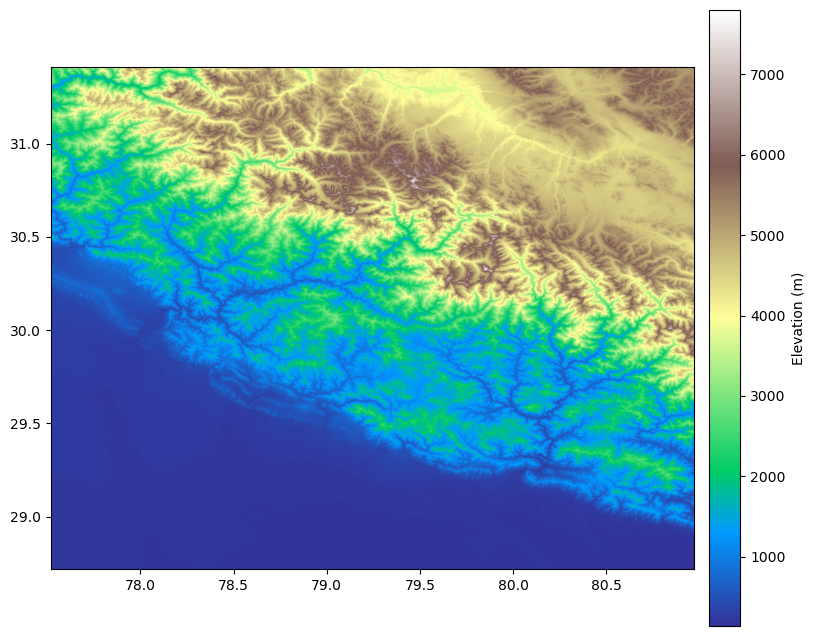

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.animation import FuncAnimation

# Function to convert DMS to decimal degrees
def dms_to_dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes / 60 + seconds / 3600
    if direction in ['S', 'W']:
        dd *= -1
    return dd

# Function to check if a point is within the given distance from another point using the Haversine formula
def covers(point, target, distance):
    return haversine(point, target) <= distance

# Function to calculate the Haversine distance between two points in kilometers
def haversine(coord1, coord2):
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Earth radius in kilometers
    r = 6371.0
    return r * c

def is_within_elevation_range(center, terrain_data, bounds):
    lat_index = int((center[0] - bounds[0]) / terrain_data.res[0])
    lon_index = int((center[1] - bounds[2]) / terrain_data.res[1])
    
    # Debugging output
    # print(f"Computed indices: lat_index={lat_index}, lon_index={lon_index}")
    # print(f"Terrain data shape: {terrain_data.shape}")

    # Check if indices are within bounds
    if lat_index < 0 or lat_index >= terrain_data.shape[0] or lon_index < 0 or lon_index >= terrain_data.shape[1]:
        return False
    
    elevation = terrain_data.read(1)[lat_index, lon_index]
    return 0 <= elevation <= 2000

# Fitness function
def fitness(particle, data, distance, terrain_data, bounds):
    total_coverage = 0
    for point in data:
        for center in particle:
            if covers(center, point, distance):
                total_coverage += 1
                break
    return total_coverage

# PSO function
def pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data):
    # Initialize particles
    particles = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=(num_particles, num_centers, 2))
    velocities = np.random.uniform(low=-1, high=1, size=(num_particles, num_centers, 2))

    # Ensure initial particles are within the elevation range
    for i in range(num_particles):
        for j in range(num_centers):
            while not is_within_elevation_range(particles[i, j], terrain_data, bounds):
                particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)

    # Initialize personal bests and global best
    p_best = particles.copy()
    p_best_fitness = np.array([fitness(p, data, distance, terrain_data, bounds) for p in particles])
    g_best = p_best[np.argmax(p_best_fitness)]
    g_best_fitness = np.max(p_best_fitness)

    # Initialize particle history
    particle_history = []

    # PSO iterations
    for iteration in range(num_iterations):
        for i in range(num_particles):
            print(iteration)
            # Update velocity
            velocities[i] = (w * velocities[i]
                             + c1 * np.random.rand() * (p_best[i] - particles[i])
                             + c2 * np.random.rand() * (g_best - particles[i]))
            # Update particle position
            particles[i] += velocities[i]
            # Boundary conditions
            particles[i] = np.clip(particles[i], [bounds[0], bounds[2]], [bounds[1], bounds[3]])

            # Ensure particles are within the elevation range
            for j in range(num_centers):
                if not is_within_elevation_range(particles[i, j], terrain_data, bounds):
                    particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)

            # Update personal best
            current_fitness = fitness(particles[i], data, distance, terrain_data, bounds)
            if current_fitness > p_best_fitness[i]:
                p_best[i] = particles[i]
                p_best_fitness[i] = current_fitness

                # Update global best
                if current_fitness > g_best_fitness:
                    g_best = particles[i]
                    g_best_fitness = current_fitness

        # Store particle positions for animation
        particle_history.append(particles.copy())

    # Return the best particles, best fitness, and particle history
    return g_best, g_best_fitness, particle_history

# # Function to check if a point is within the given distance from another point using Haversine formula
# def covers(point, target, distance):
#     return haversine(point, target) <= distance

# # Function to evaluate fitness of a particle
# def fitness(particle, data, distance, terrain_data, bounds):
#     total_coverage = 0
#     for point in data:
#         for center in particle:
#             if covers(center, point, distance):
#                 lat_index = int((point[0] - bounds[0]) / terrain_data.res[0])
#                 lon_index = int((point[1] - bounds[2]) / terrain_data.res[1])
#                 elevation = terrain_data.read(1)[lat_index, lon_index]
#                 if 0 <= elevation <= 2000:
#                     total_coverage += 1
#                     break
#     return total_coverage


# Define the PSO parameters
num_particles = 30  # Number of particles in the swarm
num_iterations = 1000  # Number of iterations to run the PSO
w = 0.5  # Inertia weight
c1 = 1.5  # Cognitive (particle) weight
c2 = 1.5  # Social (swarm) weight

# Define the bounds for the search space in decimal degrees
bounds = [
    min(dms_to_dd(28, 43, 10, 'N'), dms_to_dd(29, 57, 52, 'N'), dms_to_dd(31, 24, 35, 'N'), dms_to_dd(30, 17, 49, 'N')),
    max(dms_to_dd(28, 43, 10, 'N'), dms_to_dd(29, 57, 52, 'N'), dms_to_dd(31, 24, 35, 'N'), dms_to_dd(30, 17, 49, 'N')),  # Latitude bounds
    min(dms_to_dd(79, 58, 10, 'E'), dms_to_dd(77, 31, 10, 'E'), dms_to_dd(78, 32, 28, 'E'), dms_to_dd(80, 58, 9, 'E')),
    max(dms_to_dd(79, 58, 10, 'E'), dms_to_dd(77, 31, 10, 'E'), dms_to_dd(78, 32, 28, 'E'), dms_to_dd(80, 58, 9, 'E'))   # Longitude bounds
]

# Define the data points (converted to decimal degrees)
data = np.array([
    [dms_to_dd(30, 18, 40, 'N'), dms_to_dd(78, 2, 9, 'E')],
    [dms_to_dd(29, 56, 43, 'N'), dms_to_dd(78, 9, 4, 'E')],
    [dms_to_dd(29, 52, 43, 'N'), dms_to_dd(77, 53, 15, 'E')],
    [dms_to_dd(30, 13, 32, 'N'), dms_to_dd(78, 46, 58, 'E')],
    [dms_to_dd(30, 8, 42, 'N'), dms_to_dd(78, 45, 59, 'E')],
    [dms_to_dd(30, 24, 4, 'N'), dms_to_dd(78, 27, 51, 'E')],
    [dms_to_dd(30, 33, 44, 'N'), dms_to_dd(79, 33, 46, 'E')],
    [dms_to_dd(29, 34, 41, 'N'), dms_to_dd(79, 39, 23, 'E')],
    [dms_to_dd(29, 34, 24, 'N'), dms_to_dd(80, 15, 18, 'E')],
    [dms_to_dd(30, 46, 50, 'N'), dms_to_dd(79, 16, 23, 'E')],
    [dms_to_dd(31, 0, 38, 'N'), dms_to_dd(79, 3, 27, 'E')],
    [dms_to_dd(31, 6, 33, 'N'), dms_to_dd(78, 51, 35, 'E')],
    [dms_to_dd(31, 5, 9, 'N'), dms_to_dd(78, 35, 36, 'E')],
    [dms_to_dd(31, 1, 12, 'N'), dms_to_dd(78, 33, 7, 'E')]
])

# Set the distance for coverage in kilometers
distance = 50  # Assuming 50 km for the coverage radius

# Load the terrain data
terrain_file = "/Users/parasdhiman/Desktop/DRDO/output_SRTMGL1 2.tif"  # Replace with your actual file path
terrain_data = rasterio.open(terrain_file)

# Number of centers to find
num_centers = 6

# Find the best centers using PSO
best_points, _, particle_history = pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data)

# Create animation
fig, ax = plt.subplots(figsize=(10, 8))

# Show the terrain data with custom elevation-based colormap
terrain_image = ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')

# Add color bar for elevation
cbar = plt.colorbar(terrain_image, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Elevation (m)')

def update(frame):
    ax.clear()

    ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')
    ax.scatter(data[:, 1], data[:, 0], c='white', label='Points')

    particles = particle_history[frame]
    for particle in particles:
        ax.scatter(particle[:, 1], particle[:, 0], c='blue', alpha=0.5)

    if frame == len(particle_history) - 1:
        for center in best_points:
            ax.scatter(center[1], center[0], c='red', marker='x', s=100, label='Center')
            circle = plt.Circle((center[1], center[0]), distance / 111, color='blue', fill=False)
            ax.add_artist(circle)

    ax.set_xlim(bounds[2], bounds[3])
    ax.set_ylim(bounds[0], bounds[1])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'PSO Optimization for Center Locations (Iteration {frame + 1}/{num_iterations})')

    cbar.set_label('Elevation (m)')

    ax.legend()




0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
14
1

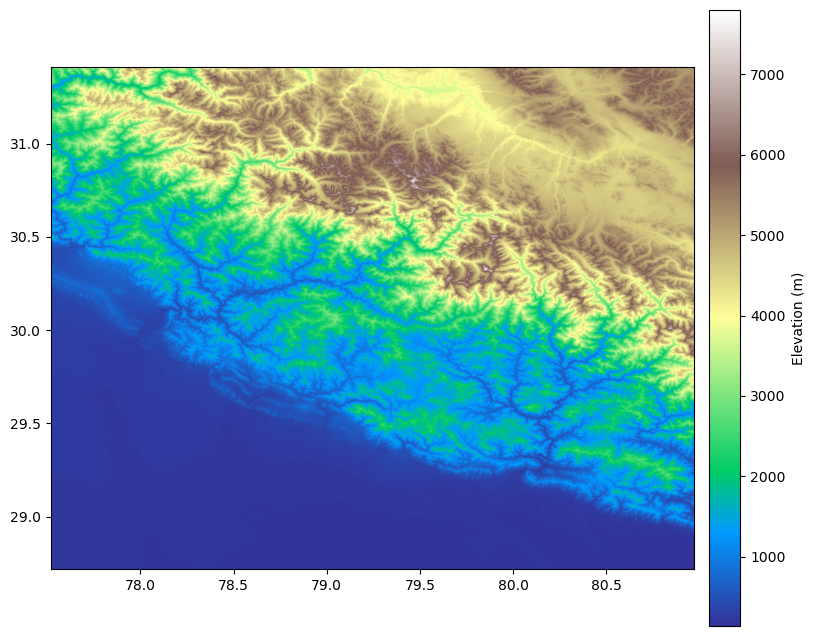

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.animation import FuncAnimation

# Function to convert DMS to decimal degrees
def dms_to_dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes / 60 + seconds / 3600
    if direction in ['S', 'W']:
        dd *= -1
    return dd

# Function to check if a point is within the given distance from another point using the Haversine formula
def covers(point, target, distance):
    return haversine(point, target) <= distance

# Function to calculate the Haversine distance between two points in kilometers
def haversine(coord1, coord2):
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Earth radius in kilometers
    r = 6371.0
    return r * c

def is_within_elevation_range(center, terrain_data, bounds):
    lat_index = int((center[0] - bounds[0]) / terrain_data.res[0])
    lon_index = int((center[1] - bounds[2]) / terrain_data.res[1])

    # Check if indices are within bounds
    if lat_index < 0 or lat_index >= terrain_data.shape[0] or lon_index < 0 or lon_index >= terrain_data.shape[1]:
        return False
    
    elevation = terrain_data.read(1)[lat_index, lon_index]
    return 0 <= elevation <= 2000

# Fitness function
def fitness(particle, data, distance, terrain_data, bounds):
    total_coverage = 0
    for point in data:
        for center in particle:
            if covers(center, point, distance):
                total_coverage += 1
                break
    return total_coverage

# PSO function
def pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data):
    # Initialize particles
    particles = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=(num_particles, num_centers, 2))
    velocities = np.random.uniform(low=-1, high=1, size=(num_particles, num_centers, 2))

    # Ensure initial particles are within the elevation range
    for i in range(num_particles):
        for j in range(num_centers):
            while not is_within_elevation_range(particles[i, j], terrain_data, bounds):
                particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)

    # Initialize personal bests and global best
    p_best = particles.copy()
    p_best_fitness = np.array([fitness(p, data, distance, terrain_data, bounds) for p in particles])
    g_best = p_best[np.argmax(p_best_fitness)]
    g_best_fitness = np.max(p_best_fitness)

    # Initialize particle history
    particle_history = []

    # PSO iterations
    for iteration in range(num_iterations):
        for i in range(num_particles):
            print(iteration)
            # Update velocity
            velocities[i] = (w * velocities[i]
                             + c1 * np.random.rand() * (p_best[i] - particles[i])
                             + c2 * np.random.rand() * (g_best - particles[i]))
            # Update particle position
            particles[i] += velocities[i]
            # Boundary conditions
            particles[i] = np.clip(particles[i], [bounds[0], bounds[2]], [bounds[1], bounds[3]])

            # Ensure particles are within the elevation range
            for j in range(num_centers):
                if not is_within_elevation_range(particles[i, j], terrain_data, bounds):
                    particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)

            # Update personal best
            current_fitness = fitness(particles[i], data, distance, terrain_data, bounds)
            if current_fitness > p_best_fitness[i]:
                p_best[i] = particles[i]
                p_best_fitness[i] = current_fitness

                # Update global best
                if current_fitness > g_best_fitness:
                    g_best = particles[i]
                    g_best_fitness = current_fitness

        # Store particle positions for animation
        particle_history.append(particles.copy())

    # Return the best particles, best fitness, and particle history
    return g_best, g_best_fitness, particle_history

# Define the PSO parameters
num_particles = 30  # Number of particles in the swarm
num_iterations = 100  # Number of iterations to run the PSO
w = 0.5  # Inertia weight
c1 = 1.5  # Cognitive (particle) weight
c2 = 1.5  # Social (swarm) weight

# Define the bounds for the search space in decimal degrees
bounds = [
    min(dms_to_dd(28, 43, 10, 'N'), dms_to_dd(29, 57, 52, 'N'), dms_to_dd(31, 24, 35, 'N'), dms_to_dd(30, 17, 49, 'N')),
    max(dms_to_dd(28, 43, 10, 'N'), dms_to_dd(29, 57, 52, 'N'), dms_to_dd(31, 24, 35, 'N'), dms_to_dd(30, 17, 49, 'N')),  # Latitude bounds
    min(dms_to_dd(79, 58, 10, 'E'), dms_to_dd(77, 31, 10, 'E'), dms_to_dd(78, 32, 28, 'E'), dms_to_dd(80, 58, 9, 'E')),
    max(dms_to_dd(79, 58, 10, 'E'), dms_to_dd(77, 31, 10, 'E'), dms_to_dd(78, 32, 28, 'E'), dms_to_dd(80, 58, 9, 'E'))   # Longitude bounds
]

# Define the data points (converted to decimal degrees)
data = np.array([
    [dms_to_dd(30, 18, 40, 'N'), dms_to_dd(78, 2, 9, 'E')],
    [dms_to_dd(29, 56, 43, 'N'), dms_to_dd(78, 9, 4, 'E')],
    [dms_to_dd(29, 52, 43, 'N'), dms_to_dd(77, 53, 15, 'E')],
    [dms_to_dd(30, 13, 32, 'N'), dms_to_dd(78, 46, 58, 'E')],
    [dms_to_dd(30, 8, 42, 'N'), dms_to_dd(78, 45, 59, 'E')],
    [dms_to_dd(30, 24, 4, 'N'), dms_to_dd(78, 27, 51, 'E')],
    [dms_to_dd(30, 33, 44, 'N'), dms_to_dd(79, 33, 46, 'E')],
    [dms_to_dd(29, 34, 41, 'N'), dms_to_dd(79, 39, 23, 'E')],
    [dms_to_dd(29, 34, 24, 'N'), dms_to_dd(80, 15, 18, 'E')],
    [dms_to_dd(30, 46, 50, 'N'), dms_to_dd(79, 16, 23, 'E')],
    [dms_to_dd(31, 0, 38, 'N'), dms_to_dd(79, 3, 27, 'E')],
    [dms_to_dd(31, 6, 33, 'N'), dms_to_dd(78, 51, 35, 'E')],
    [dms_to_dd(31, 5, 9, 'N'), dms_to_dd(78, 35, 36, 'E')],
    [dms_to_dd(31, 1, 12, 'N'), dms_to_dd(78, 33, 7, 'E')]
])

# Set the distance for coverage in kilometers
distance = 50  # Assuming 50 km for the coverage radius

# Load the terrain data
terrain_file = "/Users/parasdhiman/Desktop/DRDO/output_SRTMGL1 2.tif"  # Replace with your actual file path
terrain_data = rasterio.open(terrain_file)

# Number of centers to find
num_centers = 6

# Find the best centers
# Find the best centers using PSO
best_points, _, particle_history = pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data)

# Create animation
fig, ax = plt.subplots(figsize=(10, 8))

# Show the terrain data with custom elevation-based colormap
terrain_image = ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')

# Add color bar for elevation
cbar = plt.colorbar(terrain_image, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Elevation (m)')

def update(frame):
    ax.clear()

    ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')
    ax.scatter(data[:, 1], data[:, 0], c='white', label='Points')

    particles = particle_history[frame]
    for particle in particles:
        ax.scatter(particle[:, 1], particle[:, 0], c='blue', alpha=0.5)

    if frame == len(particle_history) - 1:
        for center in best_points:
            ax.scatter(center[1], center[0], c='red', marker='x', s=100, label='Center')
            circle = plt.Circle((center[1], center[0]), distance / 111, color='blue', fill=False)
            ax.add_artist(circle)

    ax.set_xlim(bounds[2], bounds[3])
    ax.set_ylim(bounds[0], bounds[1])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'PSO Optimization for Center Locations (Iteration {frame + 1}/{num_iterations})')

    cbar.set_label('Elevation (m)')

    ax.legend()

# Create animation
# anim = FuncAnimation(fig, update, frames=len(particle_history), interval=200)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
14
1

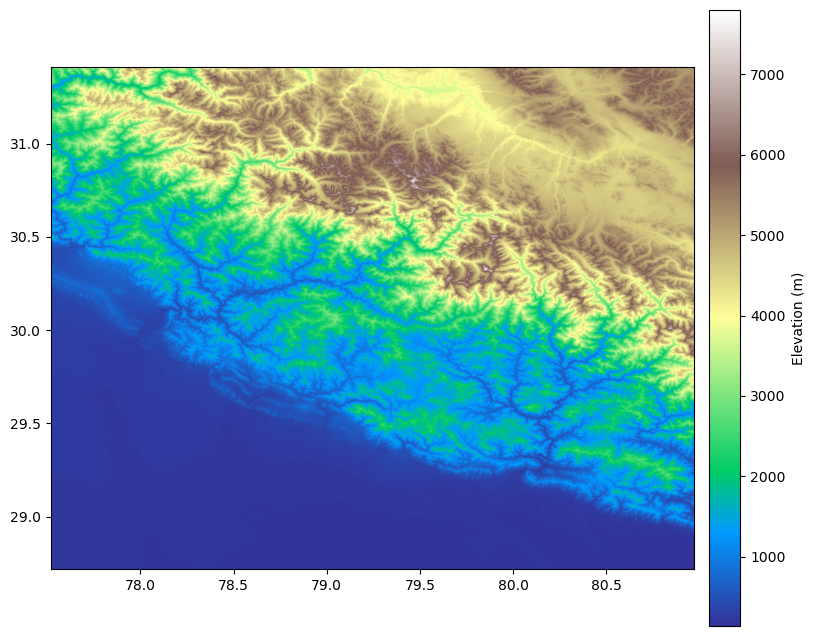

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.animation import FuncAnimation

# Function to convert DMS to decimal degrees
def dms_to_dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes / 60 + seconds / 3600
    if direction in ['S', 'W']:
        dd *= -1
    return dd

# Function to check if a point is within the given distance from another point using the Haversine formula
def covers(point, target, distance):
    return haversine(point, target) <= distance

# Function to calculate the Haversine distance between two points in kilometers
def haversine(coord1, coord2):
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Earth radius in kilometers
    r = 6371.0
    return r * c

def is_within_elevation_range(center, terrain_data, bounds):
    lat_index = int((center[0] - bounds[0]) / terrain_data.res[0])
    lon_index = int((center[1] - bounds[2]) / terrain_data.res[1])

    # Check if indices are within bounds
    if lat_index < 0 or lat_index >= terrain_data.shape[0] or lon_index < 0 or lon_index >= terrain_data.shape[1]:
        return False
    
    elevation = terrain_data.read(1)[lat_index, lon_index]
    return 0 <= elevation <= 2000

# Fitness function
def fitness(particle, data, distance, terrain_data, bounds):
    total_coverage = 0
    covered_points = set()
    for point in data:
        for center in particle:
            if covers(center, point, distance):
                total_coverage += 1
                covered_points.add(tuple(point))
                break
    return total_coverage, covered_points

# PSO function
def pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data):
    # Initialize particles
    particles = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=(num_particles, num_centers, 2))
    velocities = np.random.uniform(low=-1, high=1, size=(num_particles, num_centers, 2))

    # Ensure initial particles are within the elevation range
    for i in range(num_particles):
        for j in range(num_centers):
            while not is_within_elevation_range(particles[i, j], terrain_data, bounds):
                particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)

    # Initialize personal bests and global best
    p_best = particles.copy()
    p_best_fitness = [0] * num_particles  # Initialize as a list
    for i in range(num_particles):
        p_best_fitness[i], _ = fitness(p_best[i], data, distance, terrain_data, bounds)
    g_best_index = np.argmax(p_best_fitness)
    g_best = p_best[g_best_index].copy()
    g_best_fitness = p_best_fitness[g_best_index]
    g_best_covered = set()

    # Initialize particle history
    particle_history = [particles.copy()]
    centers_list = []
    points_covered_list = []

    # PSO iterations
    for iteration in range(num_iterations):
        all_covered = False
        
        for i in range(num_particles):
            print(iteration)
            # Update velocity
            velocities[i] = (w * velocities[i]
                             + c1 * np.random.rand() * (p_best[i] - particles[i])
                             + c2 * np.random.rand() * (g_best - particles[i]))
            # Update particle position
            particles[i] += velocities[i]
            # Boundary conditions
            particles[i] = np.clip(particles[i], [bounds[0], bounds[2]], [bounds[1], bounds[3]])

            # Ensure particles are within the elevation range
            for j in range(num_centers):
                if not is_within_elevation_range(particles[i, j], terrain_data, bounds):
                    particles[i, j] = np.random.uniform(low=[bounds[0], bounds[2]], high=[bounds[1], bounds[3]], size=2)

            # Update personal best
            current_fitness, current_covered = fitness(particles[i], data, distance, terrain_data, bounds)
            if current_fitness > p_best_fitness[i]:
                p_best[i] = particles[i].copy()
                p_best_fitness[i] = current_fitness

                # Update global best
                if current_fitness > g_best_fitness:
                    g_best = particles[i].copy()
                    g_best_fitness = current_fitness
                    g_best_covered = current_covered.copy()
                    
                    # Check if all points are covered
                    if len(g_best_covered) == len(data):
                        all_covered = True
                        
            centers_list.append(num_centers)
            points_covered_list.append(len(g_best_covered))

        # Store particle positions for animation
        particle_history.append(particles.copy())
        
        # Terminate early if all points are covered
        if all_covered:
            break

    # Return the best particles, best fitness, and particle history
    return g_best, g_best_fitness, g_best_covered, particle_history, centers_list, points_covered_list

# Define the PSO parameters
num_particles = 30  # Number of particles in the swarm
num_iterations = 100  # Number of iterations to run the PSO
w = 0.5  # Inertia weight
c1 = 1.5  # Cognitive (particle) weight
c2 = 1.5  # Social (swarm) weight

# Define the bounds for the search space in decimal degrees
bounds = [
    min(dms_to_dd(28, 43, 10, 'N'), dms_to_dd(29, 57, 52, 'N'), dms_to_dd(31, 24, 35, 'N'), dms_to_dd(30, 17, 49, 'N')),
    max(dms_to_dd(28, 43, 10, 'N'), dms_to_dd(29, 57, 52, 'N'), dms_to_dd(31, 24, 35, 'N'), dms_to_dd(30, 17, 49, 'N')),  # Latitude bounds
    min(dms_to_dd(79, 58, 10, 'E'), dms_to_dd(77, 31, 10, 'E'), dms_to_dd(78, 32, 28, 'E'), dms_to_dd(80, 58, 9, 'E')),
    max(dms_to_dd(79, 58, 10, 'E'), dms_to_dd(77, 31, 10, 'E'), dms_to_dd(78, 32, 28, 'E'), dms_to_dd(80, 58, 9, 'E'))   # Longitude bounds
]

# Define the data points (converted to decimal degrees)
data = np.array([
    [dms_to_dd(30, 18, 40, 'N'), dms_to_dd(78, 2, 9, 'E')],
    [dms_to_dd(29, 56, 43, 'N'), dms_to_dd(78, 9, 4, 'E')],
    [dms_to_dd(29, 52, 43, 'N'), dms_to_dd(77, 53, 15, 'E')],
    [dms_to_dd(30, 13, 32, 'N'), dms_to_dd(78, 46, 58, 'E')],
    [dms_to_dd(30, 8, 42, 'N'), dms_to_dd(78, 45, 59, 'E')],
    [dms_to_dd(30, 24, 4, 'N'), dms_to_dd(78, 27, 51, 'E')],
    [dms_to_dd(30, 33, 44, 'N'), dms_to_dd(79, 33, 46, 'E')],
    [dms_to_dd(29, 34, 41, 'N'), dms_to_dd(79, 39, 23, 'E')],
    [dms_to_dd(29, 34, 24, 'N'), dms_to_dd(80, 15, 18, 'E')],
    [dms_to_dd(30, 46, 50, 'N'), dms_to_dd(79, 16, 23, 'E')],
    [dms_to_dd(31, 0, 38, 'N'), dms_to_dd(79, 3, 27, 'E')],
    [dms_to_dd(31, 6, 33, 'N'), dms_to_dd(78, 51, 35, 'E')],
    [dms_to_dd(31, 5, 9, 'N'), dms_to_dd(78, 35, 36, 'E')],
    [dms_to_dd(31, 1, 12, 'N'), dms_to_dd(78, 33, 7, 'E')]
])

# Set the distance for coverage in kilometers
distance = 50  # Assuming 50 km for the coverage radius

# Load the terrain data
terrain_file = "/Users/parasdhiman/Desktop/DRDO/output_SRTMGL1 2.tif"  # Replace with your actual file path
terrain_data = rasterio.open(terrain_file)

# Number of centers to find (vary this to see how many centers are needed to cover all points)
max_centers = 6

# Find the best centers using PSO
# best_points, _, _, particle_history = pso(data, bounds, distance, num_particles, num_iterations, max_centers, terrain_data)
best_points, _, _, particle_history, centers_list, points_covered_list = pso(data, bounds, distance, num_particles, num_iterations, max_centers, terrain_data)

# Animation setup
fig, ax = plt.subplots(figsize=(10, 8))
terrain_image = ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')
cbar = plt.colorbar(terrain_image, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Elevation (m)')

def update(frame):
    ax.clear()
    ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')
    ax.scatter(data[:, 1], data[:, 0], c='white', label='Points')
    
    particles = particle_history[frame]
    for particle in particles:
        ax.scatter(particle[:, 1], particle[:, 0], c='blue', alpha=0.5)
    
    if frame == len(particle_history) - 1:
        for center in best_points:
            ax.scatter(center[:, 1], center[:, 0], c='red', marker='x', s=100, label='Center')
            circle = plt.Circle((center[:, 1], center[:, 0]), distance / 111, color='blue', fill=False)
            ax.add_artist(circle)
    
    ax.set_xlim(bounds[2], bounds[3])
    ax.set_ylim(bounds[0], bounds[1])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'PSO Optimization for Center Locations (Iteration {frame + 1}/{len(particle_history)})')
    
    cbar.set_label('Elevation (m)')
    
    ax.legend()



In [33]:
import csv
# Save data to a CSV file
csv_file = 'centers_vs_points_covered5.csv'

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Number of Centers', 'Points Covered'])

    for centers, points_covered in zip(centers_list, points_covered_list):
        writer.writerow([centers, points_covered])

print(f"Data saved to '{csv_file}' successfully.")

Data saved to 'centers_vs_points_covered5.csv' successfully.


In [37]:
import pickle

# Define the file path to save the parameters
param_file_path = 'pso_params_6chc.pkl'


# Save the parametric information
with open(param_file_path, 'wb') as f:
    pickle.dump({
        'particle_history': particle_history,
        'bounds': bounds,
        'data': data,
        'best_points': best_points,
        'distance': distance
    }, f)


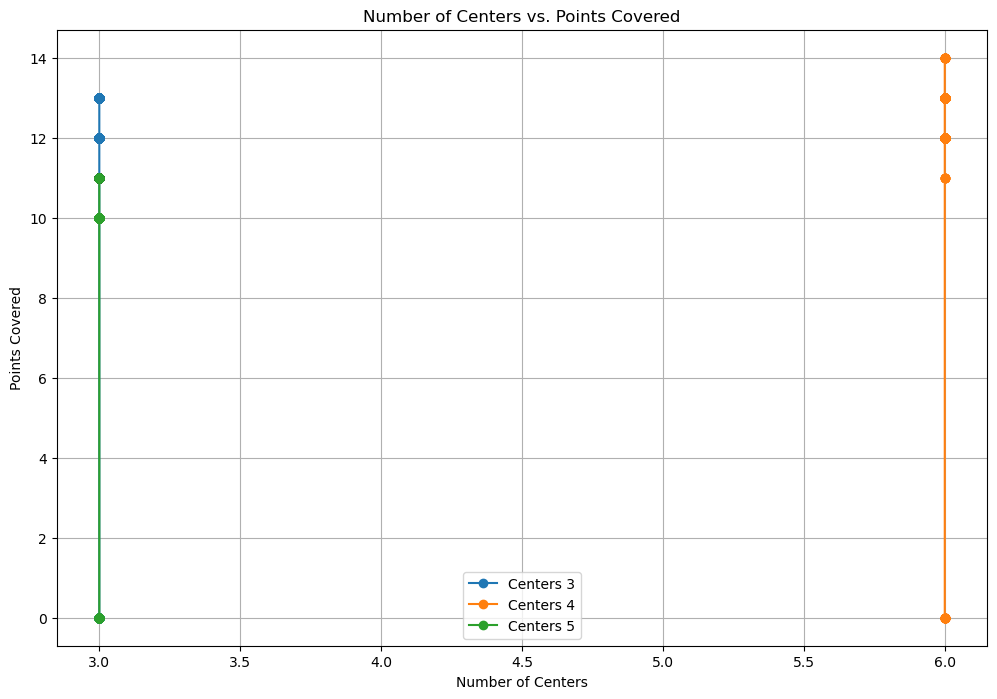

In [39]:
import csv
import matplotlib.pyplot as plt

# Function to read data from a CSV file
def read_csv_data(csv_file):
    centers = []
    points_covered = []
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header
        for row in reader:
            centers.append(int(row[0]))
            points_covered.append(int(row[1]))
    return centers, points_covered

# CSV files
csv_files = {
    'Centers 3': 'centers_vs_points_covered3.csv',
    'Centers 4': 'centers_vs_points_covered5.csv',
    'Centers 5': 'centers_vs_points_covered33.csv'
}

# Plotting the data
plt.figure(figsize=(12, 8))

for label, csv_file in csv_files.items():
    centers, points_covered = read_csv_data(csv_file)
    plt.plot(centers, points_covered, marker='o', linestyle='-', label=label)

plt.title('Number of Centers vs. Points Covered')
plt.xlabel('Number of Centers')
plt.ylabel('Points Covered')
plt.legend()
plt.grid(True)
plt.show()


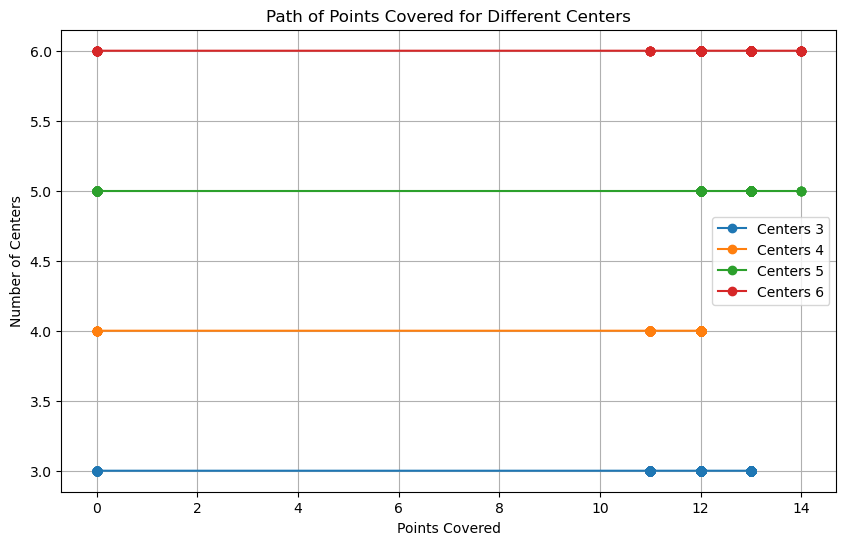

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
csv_files = {
    'Centers 3': 'centers_vs_points_covered3.csv',
    'Centers 4': 'centers_vs_points_covered4.csv',
    'Centers 5': 'centers_vs_points_covered5.csv',
    'Centers 6': 'centers_vs_points_covered6.csv'}

# Initialize a dictionary to hold dataframes
dataframes = {}

# Load data from CSV files
for key, file_path in csv_files.items():
    dataframes[key] = pd.read_csv(file_path)

# Plot the data
plt.figure(figsize=(10, 6))

for key, df in dataframes.items():
    plt.plot(df['Points Covered'], df['Number of Centers'], marker='o', label=key)

plt.ylabel('Number of Centers')
plt.xlabel('Points Covered')
plt.title('Path of Points Covered for Different Centers')
plt.legend()
plt.grid(True)
plt.show()
